## Experimento Arritmia v/s Normal

In [1]:
import pandas as pd
import glob
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from joblib import Parallel, delayed
import multiprocessing
import shap
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from neurokit2 import ecg
import neurokit2 as nk

from models.rnn import CRNN_Model


SAMPLING_RATE = 1000
SAMPLES_PER_CLASS = 2327 # (argmin = normal)
MAX_WORKERS = 8
PRE_DISPATCH = '2*n_jobs'

LEADS = ['I','II','III','aVR','aVL','aVF','V1','V2','V3','V4','V5','V6']

class_folders = {
    'block': 1,
    'normal': 0
}

data_folder = 'data'

In [2]:
def toFeature(signal: pd.core.frame.DataFrame, time = False):
    time_features = ["HRV_MeanNN", "HRV_SDNN", "HRV_RMSSD", "HRV_pNN50"]
    F = []
    for lead in LEADS:
        clean = nk.ecg_clean(signal[lead], sampling_rate=SAMPLING_RATE)
        _, rpeaks = nk.ecg_peaks(clean, sampling_rate=SAMPLING_RATE)
        rpeak_indices = rpeaks['ECG_R_Peaks']
        # Pasar de largo si no hay suficientes R-peaks
        if np.sum(rpeak_indices) < 2:
            F += [np.nan, np.nan, np.nan, np.nan]
            continue
        try:
            _, waves_peak = nk.ecg_delineate(clean, rpeaks, sampling_rate=SAMPLING_RATE, method="peak")
            mean_r = np.mean([clean[i] if not np.isnan(i) else 0 for i in rpeaks['ECG_R_Peaks']]) if np.any(rpeaks['ECG_R_Peaks']) else np.nan
            mean_p = np.mean([clean[i] if not np.isnan(i) else 0 for i in waves_peak['ECG_P_Peaks']]) if 'ECG_P_Peaks' in waves_peak else np.nan
            mean_q = np.mean([clean[i] if not np.isnan(i) else 0 for i in waves_peak['ECG_Q_Peaks']]) if 'ECG_Q_Peaks' in waves_peak else np.nan
            mean_s = np.mean([clean[i] if not np.isnan(i) else 0 for i in waves_peak['ECG_S_Peaks']]) if 'ECG_S_Peaks' in waves_peak else np.nan
        except Exception:
            mean_r = mean_p = mean_q = mean_s = np.nan
        F += [mean_r, mean_p, mean_q, mean_s]
    # Features temporales con lead II:
    clean2 = nk.ecg_clean(signal["II"], sampling_rate=SAMPLING_RATE)
    _, rpeaks = nk.ecg_peaks(clean2, sampling_rate=SAMPLING_RATE)
    valid_rpeaks = [r for r in rpeaks['ECG_R_Peaks'] if not np.isnan(r)]
    if len(valid_rpeaks) >= 2: # Seguir de largo si no hay R-peaks suficientes
        if time:
            t = nk.hrv_time(rpeaks, sampling_rate=SAMPLING_RATE)
            F.extend(t[time_features].values.flatten().tolist())
    else:
        nan_count = 0
        if time: nan_count += len(time_features)
        F.extend([np.nan] * nan_count)
    return np.array(F)

In [3]:
n_jobs = -1  
verbose = 3

def sample_paths(folder, k):
    paths = glob.glob(os.path.join(data_folder, folder, '*.parquet.gzip'))
    if len(paths) >= k:
        return random.sample(paths, k)
    else:
        return random.choices(paths, k=k)

normal_paths = sample_paths('normal', SAMPLES_PER_CLASS)
arritmia_paths = sample_paths('arritmia', SAMPLES_PER_CLASS)


file_items = [(p, 0) for p in normal_paths] + [(p, 1) for p in arritmia_paths]
random.shuffle(file_items)

def _process_file(path_label):
    path, label = path_label
    try:
        df = pd.read_parquet(path, engine='fastparquet')
        # ensure required leads
        if not set(LEADS).issubset(df.columns):
            return None, label, os.path.basename(path)
        df_leads = df[LEADS].apply(pd.to_numeric, errors='coerce').fillna(0).astype(np.float32)
        feat = toFeature(df_leads, time=True)
        return feat, label, os.path.basename(path)
    except Exception:
        return None, label, os.path.basename(path)

# choose workers
cpu_count = multiprocessing.cpu_count()
if MAX_WORKERS == -1:
    workers = max(1, cpu_count - 1)
else:
    workers = min(max(1, cpu_count - 1), MAX_WORKERS)

print(f"Running feature extraction on {len(file_items)} files with {workers} workers...")

results = Parallel(
    n_jobs=workers,
    backend='loky',
    verbose=3,
    pre_dispatch=PRE_DISPATCH
)(delayed(_process_file)(item) for item in file_items)

# find first valid feature vector length
first_valid = next((r[0] for r in results if r[0] is not None), None)
if first_valid is None:
    raise RuntimeError("No features computed successfully.")

feat_len = len(first_valid)

# build features matrix, preserving order; replace bad/mismatched with NaNs
features = np.vstack([
    (r[0] if (r[0] is not None and len(r[0]) == feat_len) else np.full(feat_len, np.nan))
    for r in results
])
labels = np.array([r[1] for r in results])
ecg_ids = [r[2] for r in results]

# impute missing values (mean)
imputer = SimpleImputer(strategy='mean')
features_imputed = imputer.fit_transform(features)

print("Features shape:", features_imputed.shape)
print("Label distribution:", dict(pd.Series(labels).value_counts()))

Running feature extraction on 4654 files with 7 workers...


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  18 tasks      | elapsed:   11.7s
[Parallel(n_jobs=7)]: Done 114 tasks      | elapsed:   43.5s
[Parallel(n_jobs=7)]: Done 274 tasks      | elapsed:  1.5min
[Parallel(n_jobs=7)]: Done 498 tasks      | elapsed:  2.5min
[Parallel(n_jobs=7)]: Done 786 tasks      | elapsed:  3.7min
[Parallel(n_jobs=7)]: Done 1138 tasks      | elapsed:  5.4min
[Parallel(n_jobs=7)]: Done 1554 tasks      | elapsed:  7.3min
[Parallel(n_jobs=7)]: Done 2034 tasks      | elapsed:  9.3min
[Parallel(n_jobs=7)]: Done 2578 tasks      | elapsed: 11.7min
[Parallel(n_jobs=7)]: Done 3186 tasks      | elapsed: 14.4min
[Parallel(n_jobs=7)]: Done 3858 tasks      | elapsed: 17.2min
[Parallel(n_jobs=7)]: Done 4594 tasks      | elapsed: 20.4min


Features shape: (4654, 52)
Label distribution: {0: np.int64(2327), 1: np.int64(2327)}


[Parallel(n_jobs=7)]: Done 4654 out of 4654 | elapsed: 20.6min finished


KNN accuracy: 0.505907626208378


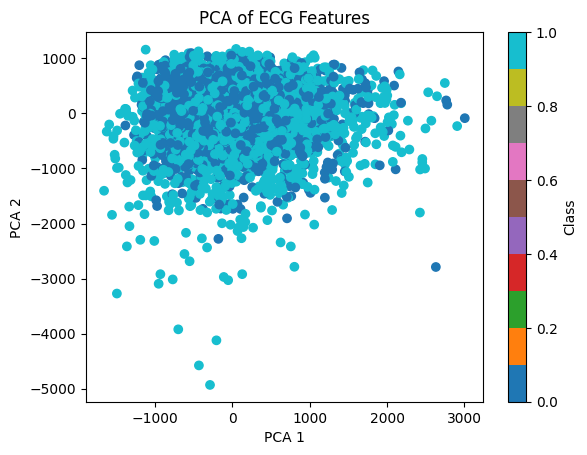

In [14]:
# PCA

pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_imputed)

# KNN

X_train, X_test, y_train, y_test = train_test_split(features_pca, labels, test_size=0.2, random_state=42)
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
print("KNN accuracy:", knn.score(X_test, y_test))

plt.scatter(features_pca[:, 0], features_pca[:, 1], c=labels, cmap='tab10')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA of ECG Features')
plt.colorbar(label='Class')
plt.show()

In [15]:
from sklearn.neural_network import MLPClassifier
X_train, X_test, y_train, y_test = train_test_split(features_imputed, labels, test_size=0.2, random_state=42)
clf = MLPClassifier(random_state=1, max_iter=30000, learning_rate='adaptive').fit(X_train, y_train)
clf.predict_proba(X_test[:1])
clf.predict(X_test[:5, :])
clf.score(X_test, y_test)

0.7207303974221267

In [16]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB().fit(X_train, y_train)
clf.score(X_test, y_test)

0.6455424274973147

In [17]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=1000, warm_start=True, n_jobs=-1)

In [18]:
rf.fit(X_train, y_train)
print(rf.n_features_in_, rf.score(X_test, y_test))

52 0.9108485499462943


In [19]:
scores = []
knn = KNeighborsClassifier(n_neighbors=4)
for n in range(51):
    pca = PCA(n_components=n+2)
    features_pca = pca.fit_transform(features_imputed)
    X_train, X_test, y_train, y_test = train_test_split(features_pca, labels, test_size=0.2, random_state=42)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))

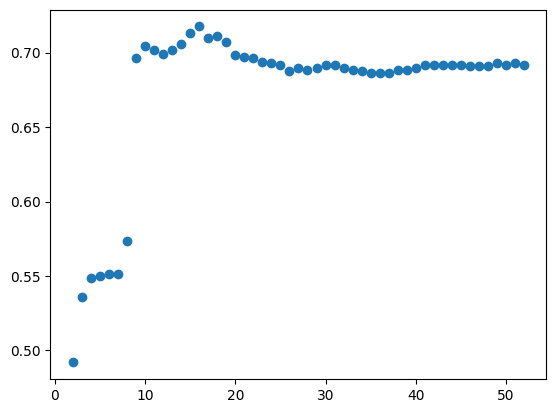

In [20]:
plt.scatter([i+2 for i in range(51)], scores)

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(features_imputed, labels, test_size=0.2, stratify=labels, random_state=42)

class_names = ['normal', 'block']

clf = RandomForestClassifier(n_estimators=1000, class_weight='balanced', n_jobs=-1, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred, target_names=class_names))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.9215896885069818

Classification report:
               precision    recall  f1-score   support

      normal       0.93      0.92      0.92       466
       block       0.92      0.93      0.92       465

    accuracy                           0.92       931
   macro avg       0.92      0.92      0.92       931
weighted avg       0.92      0.92      0.92       931


Confusion matrix:
 [[427  39]
 [ 34 431]]


In [22]:
leads = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
waves = ['R', 'P', 'Q', 'S']
hrv_features = ["HRV_MeanNN", "HRV_SDNN", "HRV_RMSSD", "HRV_pNN50"]
wave_features = [f"{lead}_{wave}" for lead in leads for wave in waves]
feature_names = wave_features + hrv_features

X_test_df = pd.DataFrame(X_test, columns=feature_names)

explainer = shap.TreeExplainer(clf)
shap_values = explainer(X_test_df)

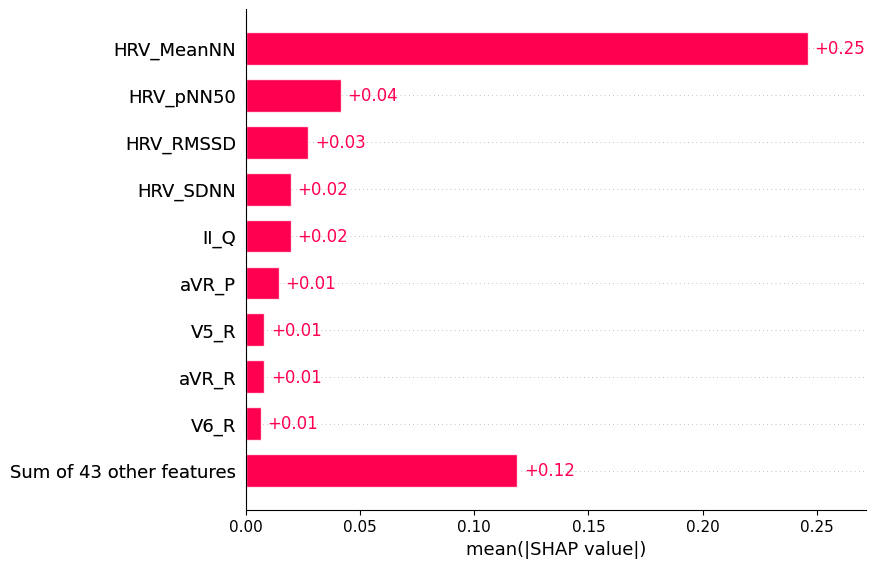

In [24]:
shap.plots.bar(shap_values[:,:,1])